Processing: noisy_10961455225_0786d3edd2_c.jpg


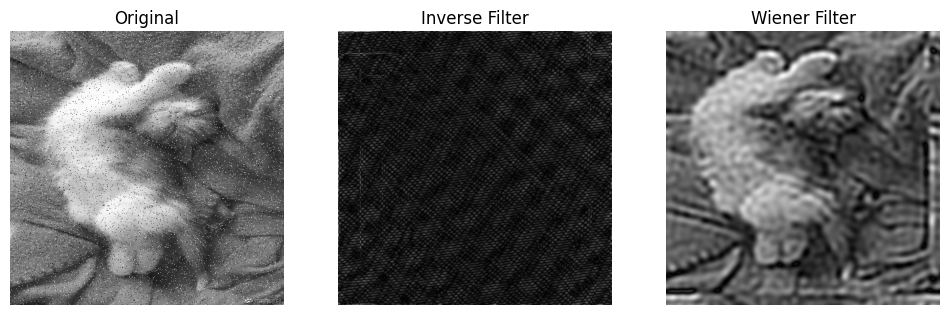

Processing: noisy_1110822219_a079aeff30_c.jpg


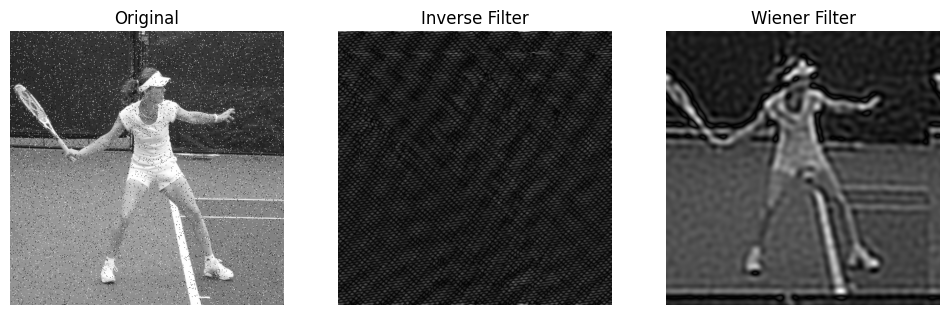

Processing: noisy_11905744206_c9273e7489_c.jpg


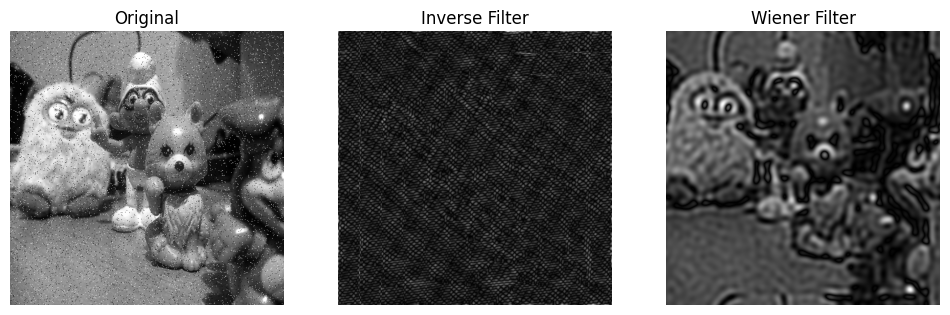

Processing: noisy_11957512115_382fbccc03_c.jpg


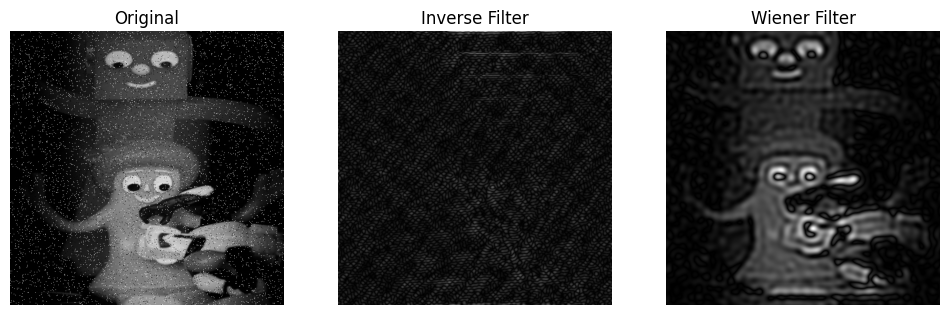

Processing: noisy_127215712_ff5b654d07_c.jpg


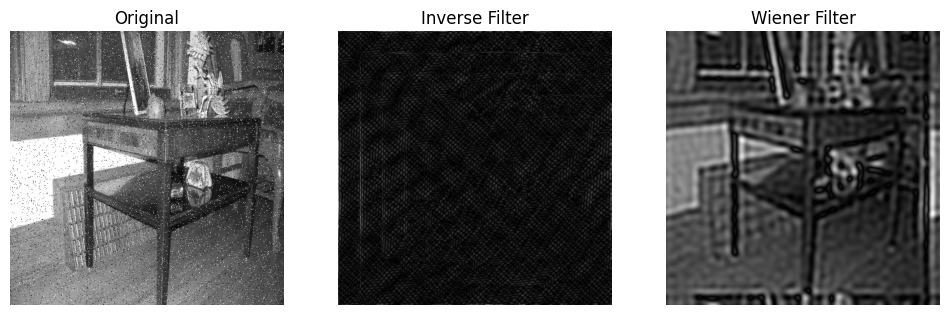

Processing: noisy_1286073711_06165cae4c_c.jpg


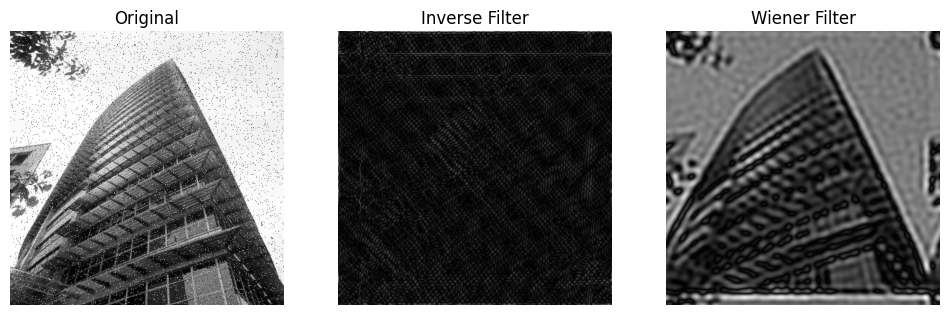

Processing: noisy_12987770865_fe17618f19_c.jpg


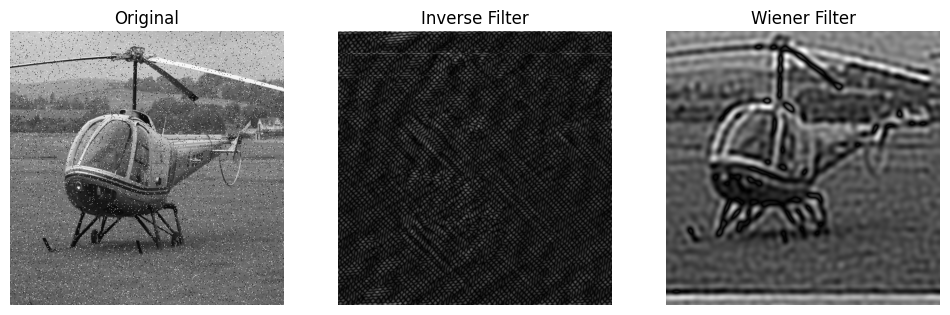

Processing: noisy_12987811255_7135b5ecbd_c.jpg


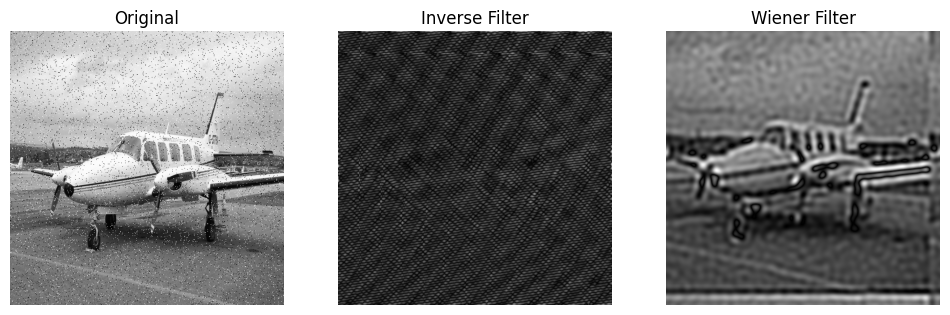

Processing: noisy_12988124424_18a549ee57_c.jpg


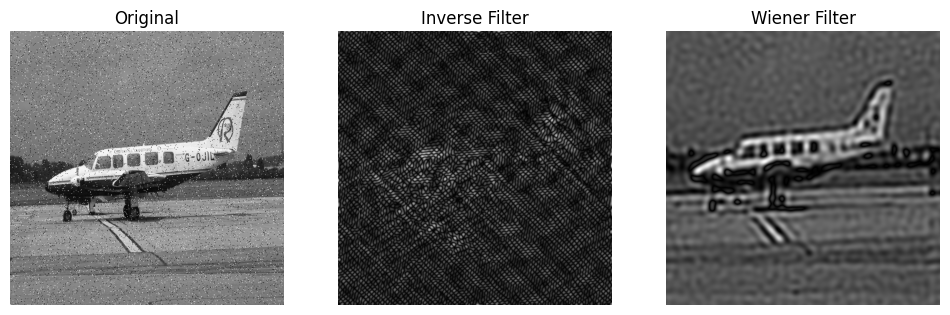

Processing: noisy_13436252374_316e4599b3_c.jpg


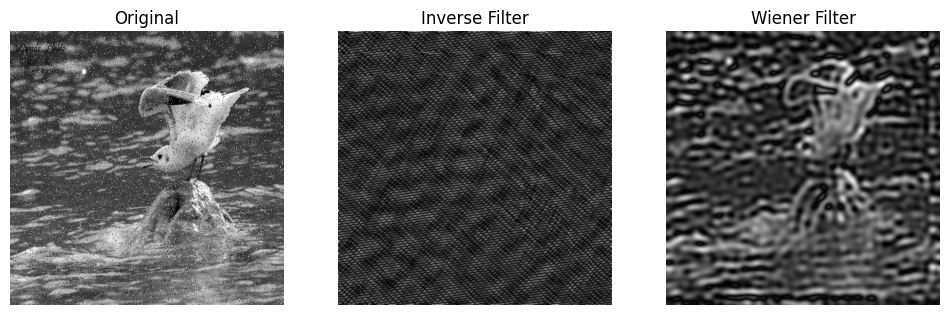

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

INPUT_DIR = r"C:\Users\amitm\Downloads\archive (7)\Noisy_folder"
OUTPUT_DIR = os.path.join(INPUT_DIR, "restored")
os.makedirs(OUTPUT_DIR, exist_ok=True)

K = 0.01
BLUR_KERNEL = 15
MAX_SHOW = 10   

def add_blur(img, ksize=7):
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

def psf_gaussian(size=41, sigma=7):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    psf /= psf.sum()
    return psf

def inverse_filter(img, psf, eps=1e-3):
    H = np.fft.fft2(psf, s=img.shape)
    G = np.fft.fft2(img)
    F = G / (H + eps)
    return np.abs(np.fft.ifft2(F))

def wiener_filter(img, psf, K=0.01):
    H = np.fft.fft2(psf, s=img.shape)
    G = np.fft.fft2(img)
    H_conj = np.conj(H)
    F = (H_conj / (H * H_conj + K)) * G
    return np.abs(np.fft.ifft2(F))

def to_uint8(img):
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)

shown = 0
for file in os.listdir(INPUT_DIR):
    if shown >= MAX_SHOW:
        break

    path = os.path.join(INPUT_DIR, file)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Could not read:", path)
        continue

    print("Processing:", file)

    blurred = add_blur(img, BLUR_KERNEL)

    psf = psf_gaussian(size=41, sigma=7)

    inv_restored = inverse_filter(blurred, psf)
    wiener_restored = wiener_filter(blurred, psf, K)

    base, ext = os.path.splitext(file)
    cv2.imwrite(os.path.join(OUTPUT_DIR, base + "_inverse" + ext), to_uint8(inv_restored))
    cv2.imwrite(os.path.join(OUTPUT_DIR, base + "_wiener" + ext), to_uint8(wiener_restored))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(inv_restored, cmap='gray'); plt.title("Inverse Filter"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(wiener_restored, cmap='gray'); plt.title("Wiener Filter"); plt.axis('off')
    plt.show(block=True)

    shown += 1
